In [1]:
from obspy import read
import obspy
%matplotlib inline
import matplotlib.pylab as plt
import os

In [2]:
from sigvisa.signals.io import fetch_waveform

In [3]:
wave = fetch_waveform("ANMO", "BHZ", 1237808444.0, 1237818444.0, pad_seconds=20,)

In [5]:
wave2 = fetch_waveform("ANMO", "BHZ", 1189294800.0, 1189294800.0+3600, pad_seconds=20,)

select chan, stime, etime, hz, npts, subdir, fname from llnl_wfdisc where sta = 'ANMO' and (chan='BHZ' or chan='bz') and stime < 1189298420.000000 and etime > 1189294780.000000 and hz > 9.0
2007.244.00.00.00.0231.IU.ANMO.00.BHZ.M.SAC
loading /media/usb0/llnl_data/ANMO/sac2007244-304/2007.244.00.00.00.0231.IU.ANMO.00.BHZ.M.SAC
read
loaded


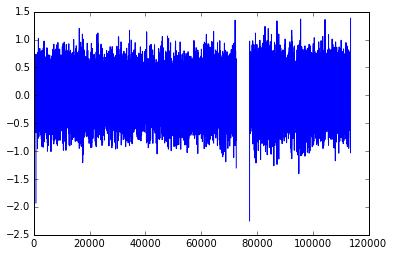

In [7]:
plt.plot(wave.filter("freq_0.8_4.5").data)

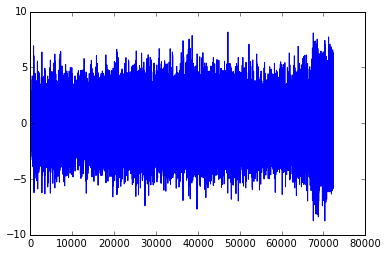

In [8]:
plt.plot(wave2.filter("freq_0.8_4.5").data)

In [13]:
from datetime import datetime

from sigvisa import Sigvisa
import time
import sys
import struct
import os
import gzip
import functools32
import numpy as np
import numpy.ma as ma

from optparse import OptionParser
from obspy.core import Trace, Stream, UTCDateTime
import obspy.signal.filter

from sigvisa.database.dataset import *
from sigvisa.signals.common import *
from sigvisa.signals.mask_util import *
        
def fetch_waveform_sac(station, chan, stime, etime, pad_seconds=20, cursor=None):
    
    
    """
    - find and load all files that are relevant to this time period
    - choose a common srate
    - allocate an array (MA) for the entire time period at that srate
    - move through files and copy over data as appropriate
    """
    
    base_dir = "/media/usb0/llnl_data/"
    
    stime = stime - pad_seconds
    etime = etime + pad_seconds

    global_stime = stime
    global_etime = etime
    
    s = Sigvisa()
    close_cursor = False
    if cursor is None:
        cursor = s.dbconn.cursor()
        close_cursor = True

    if s.earthmodel.site_info(station, stime)[3] == 1:
        cursor.execute("select refsta from static_site where sta='%s'" % station)
        options = [v[0] for v in cursor.fetchall() if v[0] != station]
        selection = options[0]
    else:
        selection = station

    if chan == "auto":
        chan = s.default_vertical_channel[selection]
    chan = s.canonical_channel_name[chan]
    chan_list = s.equivalent_channels(chan)
    
    sql = "select chan, stime, etime, hz, npts, subdir, fname from llnl_wfdisc where sta = '%s' and %s and stime < %f and etime > %f and hz > 9.0" % (
        selection, sql_multi_str("chan", chan_list), global_etime, global_stime)
    print sql
    cursor.execute(sql)
    waveforms = cursor.fetchall()
    if not waveforms:
        raise MissingWaveform("Can't find data for sta %s chan %s time %d"
                              % (station, chan, global_stime))

    if close_cursor:
        cursor.close()
    
    hzs = [wf[3] for wf in waveforms]
    hz = np.min(hzs)    
    
    npts = int((etime - stime) * hz)
    global_data = np.empty((npts,))
    global_data.fill(np.nan)
    
    for (chan, wave_stime, wave_etime, wave_hz, wave_npts, subdir, fname) in waveforms:
        print fname
        
        # at which offset into this waveform should we start collecting samples
        first_offset_time = max(stime - wave_stime, 0)
        first_offset = int(np.floor(first_offset_time * wave_hz))
        # how many samples are needed remaining
        load_start_time = wave_stime + first_offset_time
        desired_samples = int(np.floor((global_etime - load_start_time) * wave_hz))
        # how many samples are actually available
        available_samples = wave_npts - first_offset
        samples_to_read = min(desired_samples, available_samples)
        
        
        fullpath = os.path.join(base_dir, subdir, fname)
        print "loading", fullpath
        st =  obspy.read(fullpath)
        print "read"
        wave = st[0].data[first_offset:first_offset+samples_to_read]
        print "loaded"
        
        if wave_hz != hz:
            decimation = wave_hz/hz
            wave = scipy.signal.decimate(wave, decimation)
        
        # copy the data we loaded into the global array
        t_start = max(0, int((wave_stime - global_stime) * hz))
        t_end = t_start + len(wave)
        global_data[t_start:t_end] = wave

        # do we have all the data that we need
        if desired_samples <= available_samples:
            break

        # otherwise move the start time forward for the next file
        stime = wave_etime
        # and adust the end time to ensure that the correct number of samples
        # will be selected in the next file
        
    masked_data = mirror_missing(ma.masked_invalid(global_data))

    if pad_seconds > 0:
        pad_samples = int(pad_seconds * hz)
        masked_data[0:pad_samples] = ma.masked
        masked_data[-pad_samples:] = ma.masked

    return Waveform(data=masked_data, sta=selection, stime=global_stime, srate=hz, chan=chan)
        
wave = fetch_waveform_sac("YKA", "SHZ", 1189294800, 1189294800 + 7200)

select chan, stime, etime, hz, npts, subdir, fname from llnl_wfdisc where sta = 'YKR8' and (chan='SHZ' or chan='sz' or chan='szl') and stime < 1189302020.000000 and etime > 1189294780.000000 and hz > 9.0
2007.247.00.00.00.0000.CN.YKR8..SHZ.M.SAC
loading /media/usb0/llnl_data/YKA/sac2007182-273/2007.247.00.00.00.0000.CN.YKR8..SHZ.M.SAC
read
loaded


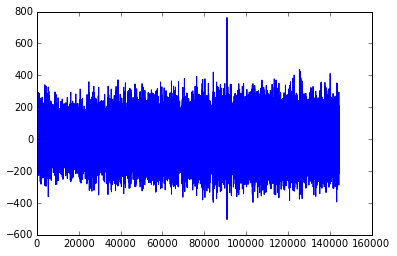

In [17]:
wf = wave.filter("freq_0.8_4.5")

plt.plot(wf.data)

In [4]:
from sigvisa import Sigvisa

def sac_to_sb():
    s = Sigvisa()
    cursor = s.dbconn.cursor()
    base_dir = "/media/usb0/llnl_data/"
    
    for site in ("PDAR", "KDAK", "ILAR", "ELK"):
        site_dir = os.path.join(base_dir, site)
        for subdir in os.listdir(site_dir):
            i = 0
            if "response" in subdir: continue
            d = os.path.join(site_dir, subdir)
            for subdir2 in os.listdir(d):
                d2 = os.path.join(d, subdir2)
                saclist = os.listdir(d2)
                for sacfile in saclist:                    
                    fullpath = os.path.join(d2, sacfile)
                    
                    st = obspy.read(fullpath, debug_headers=True, headonly=True)
                    ss = st[0].stats
                    cmd = "INSERT into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname) values ('%s', '%s', %f, %f, %f, %f, %d, '%s', '%s')"
                    fmt = cmd % (ss.station, ss.channel, 
                                 ss.starttime.timestamp, 
                                 ss.endtime.timestamp,
                                 ss.sampling_rate,
                                 ss.delta,
                                 ss.npts,
                                 os.path.join(site, subdir, subdir2),
                                 sacfile)
                    #print fmt
                    
                    
                    cursor.execute(fmt)
                    print ".",
                print
                print "inserted %d records from %s" % (len(saclist), os.path.join(site, subdir, subdir2))
                s.dbconn.commit()
                
sac_to_sb()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDAR/2007/281
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDAR/2007/182
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDAR/2007/205
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 39 records from PDAR/2007/089
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 39 records from PDAR/2007/354
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDAR/2007/101
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDAR/2007/077
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDAR/2007/266
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
inserted 36 records from PDA

In [4]:
Sigvisa().dbconn.close()

In [17]:
fullpath = "/media/usb0/llnl_data/KDAK/2007/001/KDAK.BHZ"
st = obspy.read(fullpath)
print st[0].stats

         network: 
         station: KDAK
        location: 
         channel: BHZ
       starttime: 2007-01-01T00:00:04.500000Z
         endtime: 2007-01-01T02:00:04.450000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 144000
           calib: 0.0939
         _format: SAC
             sac: AttribDict({u'dist': -12345.0, u'isynth': -12345, u'depmin': 45407.0, u'iftype': 1, u'kuser0': u'-12345  ', u'kuser1': u'-12345  ', u'kuser2': u'-12345  ', u'gcarc': -12345.0, u'iinst': -12345, u'ymaximum': -12345.0, u'kevnm': u'-12345          ', u'iqual': -12345, u'unused13': -12345, u'cmpinc': -12345.0, u'imagsrc': -12345, u'norid': -12345, u'unused11': -12345.0, u'unused10': -12345.0, u'lpspol': 0, u'unused12': -12345.0, u'leven': 1, u't8': -12345.0, u't9': -12345.0, u't6': -12345.0, u't7': -12345.0, u't4': -12345.0, u't5': -12345.0, u't2': -12345.0, u't3': -12345.0, u't0': -12345.0, u't1': -12345.0, u'istreg': -12345, u'baz': -12345.0, u'yminimum': -12345.0, u'evla': -12345.0

In [1]:
from sigvisa.signals.io import load_segments
from sigvisa import Sigvisa
s = Sigvisa()
cursor = s.dbconn.cursor()
segs = load_segments(cursor, ["ANMO",], 1167633000.0, 1167634000.0, chans = ["auto",])
seg = segs[0]

loading sta ANMO chan auto time [1167633000.0, 1167634000.0]  ... successfully loaded.


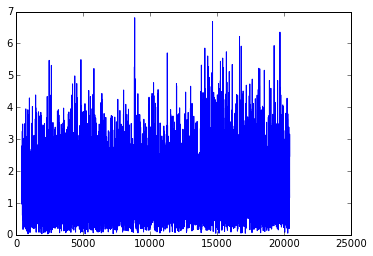

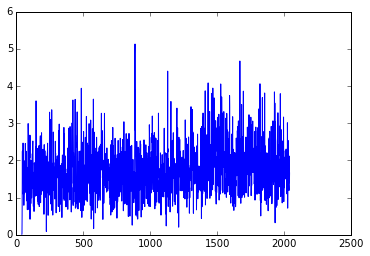

In [7]:
w = seg["BHZ"]

wwf = w.filter("freq_0.8_4.5;env")
wwfh = w.filter("freq_0.8_4.5;env;hz_2.0")
#wb = w.filter("freq_0.8_4.5")

#wbe = wb.filter("env")

plt.plot(wwf.data)
plt.figure()
plt.plot(wwfh.data)

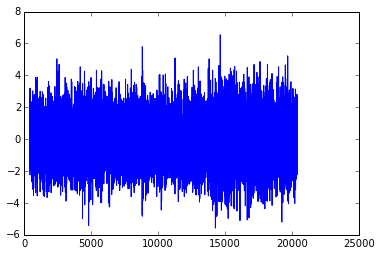

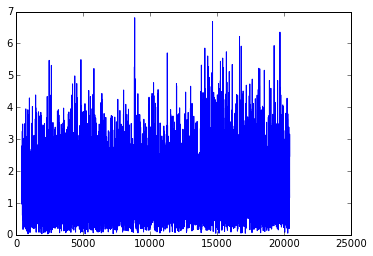

In [73]:
import obspy.signal
import numpy as np
s = wwf.data.copy()
s.data[s.mask] = 0.0
plt.plot(s)
plt.figure()
ss = obspy.signal.filter.envelope(s)
plt.plot(ss)

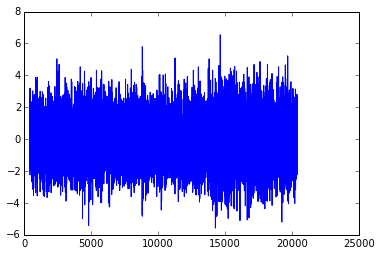

In [70]:
plt.plot(s.data)

## Import supplementary NV01 data

In [5]:
from sigvisa import Sigvisa

s = Sigvisa()
cursor = s.dbconn.cursor()
base_dir = "/media/usb0/ctbt/llnl_data/NVAR/NV01_2008049-053/"

for sacfile in os.listdir(base_dir):                    
    fullpath = os.path.join(base_dir, sacfile)

    st = obspy.read(fullpath, debug_headers=True, headonly=True)
    ss = st[0].stats
    cmd = "INSERT into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname) values ('%s', '%s', %f, %f, %f, %f, %d, '%s', '%s')"
    fmt = cmd % (ss.station, ss.channel, 
                 ss.starttime.timestamp, 
                 ss.endtime.timestamp,
                 ss.sampling_rate,
                 ss.delta,
                 ss.npts,
                 os.path.join("NVAR/NV01_2008049-053"),
                 sacfile)

    #print fmt
    cursor.execute(fmt)
    print ".",
print
s.dbconn.commit()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


NameError: name 'saclist' is not defined

# Insert supplementary TX01 data      

In [3]:
from sigvisa import Sigvisa

s = Sigvisa()
cursor = s.dbconn.cursor()
base_dir = "/media/usb0/ctbt/llnl_data/TXAR/sac2008001-091/"

with open("/home/dmoore/saclist", 'r') as f:
    lines = [l.strip() for l in f.readlines()]

for sacfile in lines:                    
    fullpath = os.path.join(base_dir, sacfile)

    st = obspy.read(fullpath, debug_headers=True, headonly=True)
    ss = st[0].stats
    cmd = "INSERT into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname) values ('%s', '%s', %f, %f, %f, %f, %d, '%s', '%s')"
    fmt = cmd % (ss.station, ss.channel, 
                 ss.starttime.timestamp, 
                 ss.endtime.timestamp,
                 ss.sampling_rate,
                 ss.delta,
                 ss.npts,
                 os.path.join("TXAR/sac2008001-091"),
                 sacfile)

    #print fmt
    cursor.execute(fmt)
    print ".",
print
s.dbconn.commit()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [4]:
from sigvisa import Sigvisa

s = Sigvisa()
cursor = s.dbconn.cursor()
base_dir = "/media/usb0/ctbt/llnl_data/YBH/sac/"

with open("/home/dmoore/saclistYBH", 'r') as f:
    lines = [l.strip() for l in f.readlines()]

for sacfile in lines:                    
    fullpath = os.path.join(base_dir, sacfile)

    st = obspy.read(fullpath, debug_headers=True, headonly=True)
    ss = st[0].stats
    cmd = "INSERT into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname) values ('%s', '%s', %f, %f, %f, %f, %d, '%s', '%s')"
    fmt = cmd % (ss.station, ss.channel, 
                 ss.starttime.timestamp, 
                 ss.endtime.timestamp,
                 ss.sampling_rate,
                 ss.delta,
                 ss.npts,
                 os.path.join("YBH/sac"),
                 sacfile)

    #print fmt
    cursor.execute(fmt)
    print ".",
print
s.dbconn.commit()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
